<a href="https://colab.research.google.com/github/8066-asad/Structural-Foundation-Design-and-Analysis-using-ML/blob/main/Predicting_Best_Model_for_Design_of_Raft_Foundations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📂 Please upload your Excel file:


Saving Expanded Design data of raft.xlsx to Expanded Design data of raft (1).xlsx
📊 Dataset shape: (500, 17)
📈 Total samples: 500

🔍 Dataset Analysis:
Missing values: 0
Duplicate rows: 0

📐 Linearity Analysis:
Bottom As (mm^2/m) X strip: Max correlation = 0.468
Top As (mm^2/m) X strip: Max correlation = 0.368
Bottom As (mm^2/m) Y strip: Max correlation = 0.568
Top As (mm^2/m) Y strip: Max correlation = 0.402
Average max correlation: 0.452
Dataset appears NON-LINEAR

🚀 Starting Comprehensive Model Selection...
🧪 Testing Multiple Models...
Testing Linear Regression...
Testing Ridge Regression...
Testing Lasso Regression...
Testing ElasticNet...
Testing Random Forest...
Testing XGBoost...
  Training XGBoost for output 1/4...
  Training XGBoost for output 2/4...
  Training XGBoost for output 3/4...
  Training XGBoost for output 4/4...
Testing Simple ANN...
Testing Micro ANN...

📊 Model Performance Results:
Linear Regression: R² = 0.3544
Ridge Regression: R² = 0.3548
Lasso Regression: R² = 

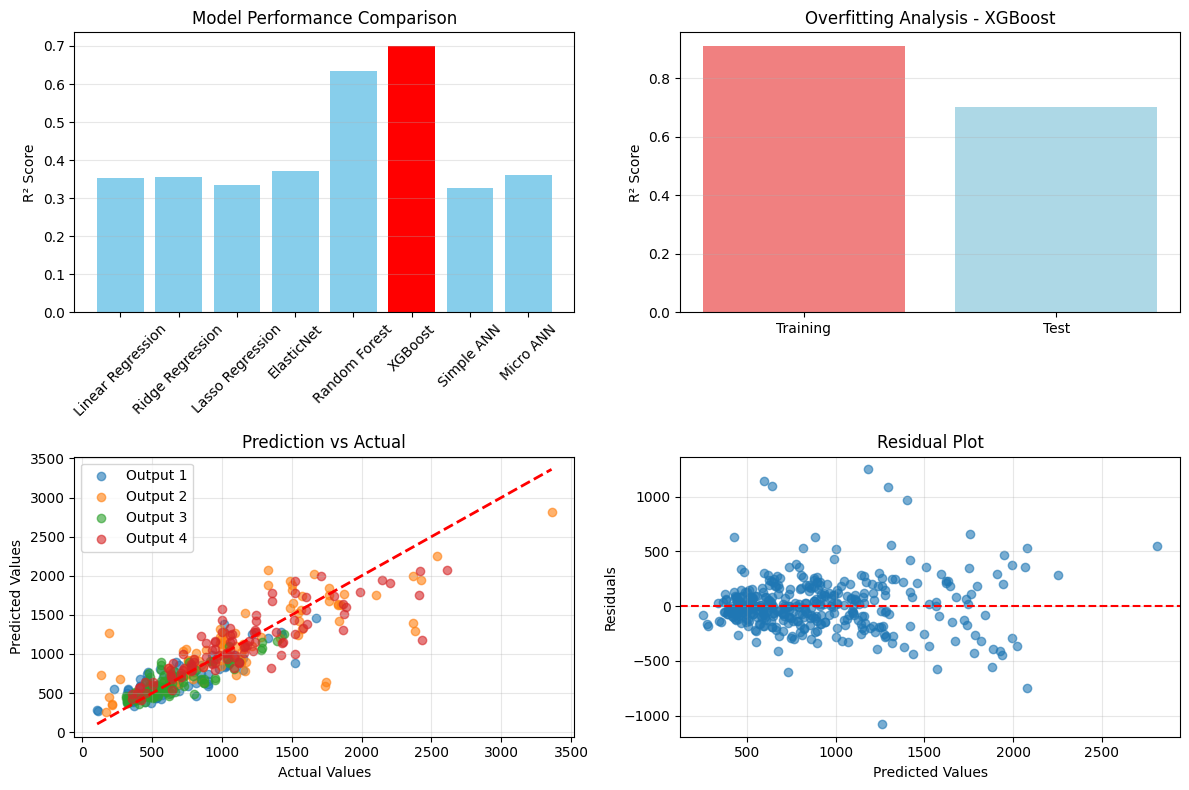


🎨 Visualization complete!
📊 Check the plots above for detailed model analysis


In [ ]:
# -------------------- STEP 0: Install Dependencies --------------------
!pip install openpyxl scikit-learn matplotlib seaborn tensorflow xgboost --quiet

# -------------------- STEP 1: Import Libraries --------------------
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2


from google.colab import files

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# -------------------- STEP 2: Upload and Analyze Dataset --------------------
print("📂 Please upload your Excel file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_excel(filename)
df.columns = df.columns.str.strip()

print(f"📊 Dataset shape: {df.shape}")
print(f"📈 Total samples: {len(df)}")

# Basic dataset analysis
print("\n🔍 Dataset Analysis:")
print("=" * 40)
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# -------------------- STEP 3: Define Inputs and Outputs --------------------
X = df[[  # Input features
    'Number of  Columns', 'Area Of Raft (m^2)', "Compressive strength of Concrete Fc' (Mpa)",
    'Concrete Unit Weight (kN/m^3)', 'Subgrade Modulus kN/m/m^2',
    'Column Area (m^2)', 'Maximum Axial Load on Column in kN',
    'Total Axial load on Column (kN)', 'Thickness of Raft (mm)',
    'Preffered Dia of Bars (mm) in Bottom direction X direction',
    'Preffered Dia of Bars (mm) X Top direction',
    'Preffered Dia of Bars (mm) Bottom Y direction',
    'Preffered Dia of Bars (mm) Top Y direction',




]]

y = df[[  # Output labels - Only areas
    'Bottom As (mm^2/m) X strip',
    'Top As (mm^2/m) X strip',
    'Bottom As (mm^2/m) Y strip',
    'Top As (mm^2/m) Y strip'
]]

# Check for linearity
print("\n📐 Linearity Analysis:")
print("=" * 30)
correlations = []
for i, col in enumerate(y.columns):
    corr_matrix = np.corrcoef(X.values.T, y.iloc[:, i].values)
    max_corr = np.max(np.abs(corr_matrix[:-1, -1]))
    correlations.append(max_corr)
    print(f"{col}: Max correlation = {max_corr:.3f}")

avg_correlation = np.mean(correlations)
print(f"Average max correlation: {avg_correlation:.3f}")
is_linear = avg_correlation > 0.7
print(f"Dataset appears {'LINEAR' if is_linear else 'NON-LINEAR'}")

# -------------------- STEP 4: Mathematical Calculation Functions --------------------
def calculate_bar_spacing_and_count(area_required, bar_diameter, strip_width=1000):
    """Calculate spacing and number of bars based on structural design principles"""
    area_required = max(area_required, 0)
    bar_area = (math.pi * bar_diameter**2) / 4

    if bar_area <= 0:
        return 200, 1

    num_bars_per_meter = area_required / bar_area

    if num_bars_per_meter > 0:
        spacing = strip_width / num_bars_per_meter
        spacing = round(spacing / 5) * 5
        num_bars = math.ceil(strip_width / spacing) + 1
    else:
        spacing = strip_width
        num_bars = 1

    min_spacing = max(3 * bar_diameter, 75)
    max_spacing = 200
    spacing = max(min_spacing, min(spacing, max_spacing))
    num_bars = math.ceil(strip_width / spacing) + 1

    return spacing, num_bars

def predict_with_calculations(y_pred_areas, X_original):
    """Predict areas and calculate spacing and number of bars"""
    all_predictions = np.zeros((y_pred_areas.shape[0], 12))

    for i in range(y_pred_areas.shape[0]):
        # Get bar diameters - Access from X_original using the index i
        bottom_x_dia = X_original.iloc[i]['Preffered Dia of Bars (mm) in Bottom direction X direction']
        top_x_dia = X_original.iloc[i]['Preffered Dia of Bars (mm) X Top direction']
        bottom_y_dia = X_original.iloc[i]['Preffered Dia of Bars (mm) Bottom Y direction']
        top_y_dia = X_original.iloc[i]['Preffered Dia of Bars (mm) Top Y direction']

        # Ensure y_pred_areas[i] is a 1D array before creating 'areas' list
        current_areas = y_pred_areas[i]
        if len(current_areas.shape) > 1:
             current_areas = current_areas.flatten()

        areas = [max(area, 0) for area in current_areas]
        diameters = [bottom_x_dia, top_x_dia, bottom_y_dia, top_y_dia]

        for j, (area, dia) in enumerate(zip(areas, diameters)):
            spacing, num_bars = calculate_bar_spacing_and_count(area, dia)
            all_predictions[i, j*3:(j+1)*3] = [area, spacing, num_bars]

    return all_predictions

# -------------------- STEP 5: Model Definitions --------------------
def create_simple_ann(input_dim, output_dim, dropout_rate=0.2, l1_reg=0.001, l2_reg=0.001):
    """Create a simple ANN optimized for small datasets"""
    model = Sequential([
        Dense(32, input_dim=input_dim, activation='relu',
              kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(16, activation='relu',
              kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)),
        Dropout(dropout_rate),

        Dense(output_dim, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def create_micro_ann(input_dim, output_dim):
    """Create a micro ANN for very small datasets"""
    model = Sequential([
        Dense(16, input_dim=input_dim, activation='relu',
              kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.3),
        Dense(8, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dense(output_dim, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

# -------------------- STEP 6: Model Evaluation with Cross-Validation --------------------
def evaluate_model_cv(model, X, y, cv_folds=5, model_name="Model"):
    """Evaluate model using cross-validation"""

    if hasattr(model, 'fit') and hasattr(model, 'predict'):
        # Sklearn model
        scores = []
        kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

        for output_idx in range(y.shape[1]):
            y_single = y.iloc[:, output_idx]
            cv_scores = cross_val_score(model, X, y_single, cv=kfold, scoring='r2')
            scores.append(cv_scores.mean())

        return np.mean(scores), np.std(scores)
    else:
        # Neural network model
        kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
        scores = []

        for train_idx, val_idx in kfold.split(X):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

            # Create and train model
            temp_model = model()
            temp_model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=16,
                          validation_data=(X_val_fold, y_val_fold), verbose=0,
                          callbacks=[EarlyStopping(patience=15, restore_best_weights=True)])

            # Predict and calculate R²
            y_pred = temp_model.predict(X_val_fold, verbose=0)
            fold_scores = []
            for i in range(y_val_fold.shape[1]):
                r2 = r2_score(y_val_fold.iloc[:, i], y_pred[:, i])
                fold_scores.append(r2)

            scores.append(np.mean(fold_scores))

        return np.mean(scores), np.std(scores)

# -------------------- STEP 7: Comprehensive Model Testing --------------------
def test_all_models(X, y, test_size=0.2):
    """Test multiple models and return the best one"""

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Scale data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Robust scaling for comparison
    robust_scaler_X = RobustScaler()
    robust_scaler_y = RobustScaler()

    X_train_robust = robust_scaler_X.fit_transform(X_train)
    X_test_robust = robust_scaler_X.transform(X_test)
    y_train_robust = robust_scaler_y.fit_transform(y_train)
    y_test_robust = robust_scaler_y.transform(y_test)


    results = {}

    print("🧪 Testing Multiple Models...")
    print("=" * 50)

    # 1. Linear Regression
    print("Testing Linear Regression...")
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train_scaled)
    lr_pred = scaler_y.inverse_transform(lr_model.predict(X_test_scaled))
    lr_r2 = np.mean([r2_score(y_test.iloc[:, i], lr_pred[:, i]) for i in range(y_test.shape[1])])
    results['Linear Regression'] = {'model': lr_model, 'r2': lr_r2, 'scaler_X': scaler_X, 'scaler_y': scaler_y}

    # 2. Ridge Regression
    print("Testing Ridge Regression...")
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train_scaled, y_train_scaled)
    ridge_pred = scaler_y.inverse_transform(ridge_model.predict(X_test_scaled))
    ridge_r2 = np.mean([r2_score(y_test.iloc[:, i], ridge_pred[:, i]) for i in range(y_test.shape[1])])
    results['Ridge Regression'] = {'model': ridge_model, 'r2': ridge_r2, 'scaler_X': scaler_X, 'scaler_y': scaler_y}

    # 3. Lasso Regression
    print("Testing Lasso Regression...")
    lasso_model = Lasso(alpha=0.1)
    lasso_model.fit(X_train_scaled, y_train_scaled)
    lasso_pred = scaler_y.inverse_transform(lasso_model.predict(X_test_scaled))
    lasso_r2 = np.mean([r2_score(y_test.iloc[:, i], lasso_pred[:, i]) for i in range(y_test.shape[1])])
    results['Lasso Regression'] = {'model': lasso_model, 'r2': lasso_r2, 'scaler_X': scaler_X, 'scaler_y': scaler_y}

    # 4. ElasticNet
    print("Testing ElasticNet...")
    elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
    elastic_model.fit(X_train_scaled, y_train_scaled)
    elastic_pred = scaler_y.inverse_transform(elastic_model.predict(X_test_scaled))
    elastic_r2 = np.mean([r2_score(y_test.iloc[:, i], elastic_pred[:, i]) for i in range(y_test.shape[1])])
    results['ElasticNet'] = {'model': elastic_model, 'r2': elastic_r2, 'scaler_X': scaler_X, 'scaler_y': scaler_y}

    # 5. Random Forest (with reduced complexity)
    print("Testing Random Forest...")
    rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42))
    rf_model.fit(X_train_scaled, y_train)
    rf_pred = rf_model.predict(X_test_scaled)
    rf_r2 = np.mean([r2_score(y_test.iloc[:, i], rf_pred[:, i]) for i in range(y_test.shape[1])])
    results['Random Forest'] = {'model': rf_model, 'r2': rf_r2, 'scaler_X': scaler_X, 'scaler_y': None}


    # 6. XGBoost
    print("Testing XGBoost...")
    # Train a separate XGBoost model for each output
    xgb_models = []
    xgb_preds = np.zeros_like(y_test)
    xgb_r2_scores = []

    for i in range(y.shape[1]):
        print(f"  Training XGBoost for output {i+1}/{y.shape[1]}...")
        xgb_model_single = xgb.XGBRegressor(**{'max_depth': 4,
            'min_child_weight': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'learning_rate': 0.05,
            'n_estimators': 1000,
            'early_stopping_rounds': 50,
            'random_state': 42}) # Added random_state for reproducibility

        xgb_model_single.fit(X_train_scaled, y_train.iloc[:, i],
                             eval_set=[(X_test_scaled, y_test.iloc[:, i])],
                             verbose=False)
        xgb_preds[:, i] = xgb_model_single.predict(X_test_scaled)
        xgb_r2_scores.append(r2_score(y_test.iloc[:, i], xgb_preds[:, i]))
        xgb_models.append(xgb_model_single)

    xgb_r2 = np.mean(xgb_r2_scores)
    # Store the list of models for prediction later
    results['XGBoost'] = {'model': xgb_models, 'r2': xgb_r2, 'scaler_X': scaler_X, 'scaler_y': None}


    # 7. Simple ANN
    print("Testing Simple ANN...")
    ann_model = create_simple_ann(X_train_scaled.shape[1], y_train_scaled.shape[1])
    ann_model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16,
                  validation_split=0.2, verbose=0,
                  callbacks=[EarlyStopping(patience=15, restore_best_weights=True), ReduceLROnPlateau(patience=10)])
    ann_pred = scaler_y.inverse_transform(ann_model.predict(X_test_scaled, verbose=0))
    ann_r2 = np.mean([r2_score(y_test.iloc[:, i], ann_pred[:, i]) for i in range(y_test.shape[1])])
    results['Simple ANN'] = {'model': ann_model, 'r2': ann_r2, 'scaler_X': scaler_X, 'scaler_y': scaler_y}


    # 8. Micro ANN
    print("Testing Micro ANN...")
    micro_model = create_micro_ann(X_train_scaled.shape[1], y_train_scaled.shape[1])
    micro_model.fit(X_train_scaled, y_train_scaled, epochs=150, batch_size=8,
                    validation_split=0.2, verbose=0,
                    callbacks=[EarlyStopping(patience=20, restore_best_weights=True), ReduceLROnPlateau(patience=15)])
    micro_pred = scaler_y.inverse_transform(micro_model.predict(X_test_scaled, verbose=0))
    micro_r2 = np.mean([r2_score(y_test.iloc[:, i], micro_pred[:, i]) for i in range(y_test.shape[1])])
    results['Micro ANN'] = {'model': micro_model, 'r2': micro_r2, 'scaler_X': scaler_X, 'scaler_y': scaler_y}


    return results, X_train, X_test, y_train, y_test


# -------------------- STEP 8: Run Model Selection --------------------
print("\n🚀 Starting Comprehensive Model Selection...")
print("=" * 60)

model_results, X_train, X_test, y_train, y_test = test_all_models(X, y)

# Display results
print("\n📊 Model Performance Results:")
print("=" * 40)
for model_name, result in model_results.items():
    print(f"{model_name}: R² = {result['r2']:.4f}")

# Select best model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['r2'])
best_model_info = model_results[best_model_name]
best_model = best_model_info['model']
best_scaler_X = best_model_info['scaler_X']
best_scaler_y = best_model_info['scaler_y']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"🎯 Best R² Score: {best_model_info['r2']:.4f}")

# -------------------- STEP 9: Detailed Evaluation of Best Model --------------------
print(f"\n📈 Detailed Evaluation of {best_model_name}:")
print("=" * 50)

# Prepare data for best model
X_test_scaled = best_scaler_X.transform(X_test)

# Make predictions
if best_model_name == 'XGBoost':
    y_pred_areas = np.zeros_like(y_test)
    for i, model in enumerate(best_model):
        y_pred_areas[:, i] = model.predict(X_test_scaled)
elif best_scaler_y is not None:
    # Models that use output scaling
    if hasattr(best_model, 'predict'):
        y_pred_scaled = best_model.predict(X_test_scaled)
        if len(y_pred_scaled.shape) == 1:
            y_pred_scaled = y_pred_scaled.reshape(-1, 1)
        y_pred_areas = best_scaler_y.inverse_transform(y_pred_scaled)
    else:
        # Neural network
        y_pred_scaled = best_model.predict(X_test_scaled, verbose=0)
        y_pred_areas = best_scaler_y.inverse_transform(y_pred_scaled)
else:
    # Models that don't use output scaling
    y_pred_areas = best_model.predict(X_test_scaled)

# Calculate metrics
area_features = y.columns.tolist()
print("\nArea Prediction Performance:")
for i, feature in enumerate(area_features):
    r2 = r2_score(y_test.iloc[:, i], y_pred_areas[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred_areas[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred_areas[:, i]))
    print(f"{feature}:")
    print(f"  R² = {r2*100:.2f}%,  MAE = {mae:.2f},  RMSE = {rmse:.2f}")

# -------------------- STEP 10: Generate Full Predictions --------------------
y_pred_full = predict_with_calculations(y_pred_areas, X_test)

# Display sample predictions
print("\n📋 Sample Predictions with Calculated Values:")
print("=" * 80)

all_output_labels = [
    'Bottom As (mm²/m) X strip', 'Spacing (mm) Bottom X', 'Number of Bars for Bottom in X direction',
    'Top As (mm²/m) X strip', 'Spacing (mm) Top X', 'Number of Bars Top X',
    'Bottom As (mm²/m) Y strip', 'Spacing (mm) Bottom Y', 'Number of Bars Bottom Y',
    'Top As (mm²/m) Y strip', 'Spacing(mm) Top Y', 'Number of Bars Top Y'
]

for idx in range(min(3, len(X_test))):
    print(f"\nSample {idx + 1}:")
    print("-" * 40)
    for j, label in enumerate(all_output_labels):
        predicted = y_pred_full[idx, j]
        if j < 4:  # Area predictions
            print(f"{label}: {predicted:.2f} mm²/m")
        elif j in [1, 4, 7, 10]:  # Spacing predictions
            print(f"{label}: {predicted:.0f} mm")
        else:  # Number of bars predictions
            print(f"{label}: {predicted:.0f} bars")

# -------------------- STEP 11: Overfitting Analysis --------------------
print(f"\n🔍 Overfitting Analysis for {best_model_name}:")
print("=" * 50)

# Training performance
X_train_scaled = best_scaler_X.transform(X_train)

# Calculate training and test R²
if best_model_name == 'XGBoost':
    y_train_pred_areas = np.zeros_like(y_train)
    for i, model in enumerate(best_model):
        y_train_pred_areas[:, i] = model.predict(X_train_scaled)
elif best_scaler_y is not None:
    if hasattr(best_model, 'predict'):
        y_train_pred_scaled = best_model.predict(X_train_scaled)
        if len(y_train_pred_scaled.shape) == 1:
            y_train_pred_scaled = y_train_pred_scaled.reshape(-1, 1)
        y_train_pred_areas = best_scaler_y.inverse_transform(y_train_pred_scaled)
    else:
        y_train_pred_scaled = best_model.predict(X_train_scaled, verbose=0)
        y_train_pred_areas = best_scaler_y.inverse_transform(y_train_pred_scaled)
else:
    y_train_pred_areas = best_model.predict(X_train_scaled)

train_r2 = np.mean([r2_score(y_train.iloc[:, i], y_train_pred_areas[:, i]) for i in range(y_train.shape[1])])
test_r2 = np.mean([r2_score(y_test.iloc[:, i], y_pred_areas[:, i]) for i in range(y_test.shape[1])])

print(f"Training R²: {train_r2*100:.2f}%")
print(f"Test R²: {test_r2*100:.2f}%")
print(f"Difference: {(train_r2 - test_r2)*100:.2f}%")

if abs(train_r2 - test_r2) < 0.05:
    print("✅ Excellent generalization - No overfitting detected!")
elif abs(train_r2 - test_r2) < 0.1:
    print("🟡 Good generalization - Minimal overfitting")
else:
    print("⚠️ Potential overfitting detected")

# -------------------- STEP 12: Save Best Model --------------------
print(f"\n💾 Saving Best Model ({best_model_name})...")


# -------------------- STEP 13: Final Prediction Function --------------------
def predict_new_sample_best(input_features):
    """
    Predict reinforcement details using the best selected model
    Args:
        input_features (pd.DataFrame): A DataFrame with a single row containing the input features for prediction.
                                       The column names must match the input features used for training (X).
    Returns:
        pd.DataFrame: A DataFrame containing the predicted reinforcement areas, spacing, and number of bars.
    """
    # Ensure input_features is a DataFrame
    if not isinstance(input_features, pd.DataFrame):
        raise TypeError("input_features must be a pandas DataFrame.")

    # Ensure input_features has the correct columns
    required_input_cols = X.columns.tolist()
    if not all(col in input_features.columns for col in required_input_cols):
         raise ValueError(f"Input DataFrame must contain the following columns: {required_input_cols}")

    # Ensure input_features has only one row
    if len(input_features) != 1:
        raise ValueError("Input DataFrame must contain exactly one row for prediction.")

    # Scale the input features using the best scaler
    input_scaled = best_scaler_X.transform(input_features)

    # Make predictions using the best model
    if best_model_name == 'XGBoost':
        # Predict each output using its corresponding trained XGBoost model
        y_pred_areas = np.zeros((1, len(best_model)))
        for i, model in enumerate(best_model):
            y_pred_areas[:, i] = model.predict(input_scaled)
    elif best_scaler_y is not None:
        # Models that use output scaling
        y_pred_scaled = best_model.predict(input_scaled)
        if len(y_pred_scaled.shape) == 1:
            y_pred_scaled = y_pred_scaled.reshape(-1, 1)
        y_pred_areas = best_scaler_y.inverse_transform(y_pred_scaled)
    else:
        # Models that don't use output scaling
        y_pred_areas = best_model.predict(input_scaled)

    # Use the predict_with_calculations function to get full details
    # Need to pass the original input features for bar diameters
    y_pred_full = predict_with_calculations(y_pred_areas, input_features)

    # Create a DataFrame for the full predictions
    all_output_labels = [
        'Bottom As (mm²/m) X strip', 'Spacing (mm) Bottom X', 'Number of Bars for Bottom in X direction',
        'Top As (mm²/m) X strip', 'Spacing (mm) Top X', 'Number of Bars Top X',
        'Bottom As (mm²/m) Y strip', 'Spacing (mm) Bottom Y', 'Number of Bars Bottom Y',
        'Top As (mm²/m) Y strip', 'Spacing(mm) Top Y', 'Number of Bars Top Y'
    ]
    predictions_df = pd.DataFrame(y_pred_full, columns=all_output_labels)

    return predictions_df


print(f"\n✅ Model Selection Complete!")
print(f"🏆 Best performing model: {best_model_name}")
print(f"📊 Final R² Score: {best_model_info['r2']:.4f}")
print(f"🛡️ Overfitting difference: {abs(train_r2 - test_r2)*100:.2f}%")
print(f"💡 Recommendation: Use {best_model_name} for production")


# -------------------- STEP 14: Model Comparison Visualization --------------------
plt.figure(figsize=(12, 8))

# Plot 1: Model comparison
plt.subplot(2, 2, 1)
models = list(model_results.keys())
scores = [model_results[model]['r2'] for model in models]
colors = ['red' if model == best_model_name else 'skyblue' for model in models]

plt.bar(models, scores, color=colors)
plt.title('Model Performance Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Plot 2: Overfitting analysis
plt.subplot(2, 2, 2)
plt.bar(['Training', 'Test'], [train_r2, test_r2], color=['lightcoral', 'lightblue'])
plt.title(f'Overfitting Analysis - {best_model_name}')
plt.ylabel('R² Score')
plt.grid(axis='y', alpha=0.3)

# Plot 3: Prediction vs Actual (for best model)
plt.subplot(2, 2, 3)
for i in range(y_test.shape[1]):
    plt.scatter(y_test.iloc[:, i], y_pred_areas[:, i], alpha=0.6, label=f'Output {i+1}')
plt.plot([y_test.min().min(), y_test.max().max()], [y_test.min().min(), y_test.max().max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual')
plt.legend()
plt.grid(alpha=0.3)

# Plot 4: Residuals
plt.subplot(2, 2, 4)
residuals = y_test.values - y_pred_areas
plt.scatter(y_pred_areas.flatten(), residuals.flatten(), alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎨 Visualization complete!")
print("📊 Check the plots above for detailed model analysis")